# Parallel stochastic simulation

Stochastic simulation is an [embarrassingly parallel problem](https://en.wikipedia.org/wiki/Embarrassingly_parallel) in which realizations are only a function of the random seed, and can be generated indenpendently one from another. Although this is a well-known fact, there has not been reasonable effort in geostatistical software to exploit modern hardware such as HPC clusters and the cloud (e.g. AWS, MS Azure).

In GeoStats.jl, *all* stochastic simulation algorithms generate realizations in parallel by default. The package exploits Julia's built-in support for parallel execution, and works seamlessly on personal laptops with multiple cores as well as on high-performance computer clusters with multiple nodes.

In this tutorial, we demonstrate how to generate realizations with sequential Gaussian simulation in parallel. The same script can be run on a computer cluster where thousands of processes are available.

Before we proceed, please install the following packages:

In [1]:
for pkg in ["GeoStats", "Plots", "PyPlot"]
    Pkg.add(pkg)
end

# make sure this tutorial is reproducible
srand(2000);

INFO: Package GeoStats is already installed
INFO: Package Plots is already installed
INFO: Package PyPlot is already installed


## Number of processes

When you start Julia, it starts with a single process:

In [2]:
nprocs()

1

In order to run simulations in parallel with GeoStats.jl, the first thing we need to do is increase the number of processes in the pool *before* loading the package. The command `addprocs` adds a given number of processes for parallel execution:

In [3]:
addprocs()

4-element Array{Int64,1}:
 2
 3
 4
 5

Notice that `addprocs()` when called without an argument, adds the number of *logical* cores available in the machine.

> **WARNING:** If you are on Windows 8 or an older version of the operating system, you will likely experience a slow down. Please add the number of *physical* cores instead that can be found externally in computer settings or via the [Hwloc.jl](https://github.com/JuliaParallel/Hwloc.jl) package.

On a HPC cluster, computing resources are generally requested via a resource manager (e.g. SLURM, PBS). In this case, the package [ClusterManagers.jl](https://github.com/JuliaParallel/ClusterManagers.jl) provides variants of the built-in `addprocs()` for adding processes to the pool effortlessly. For example, we can use `addprocs_slurm(1000)` to request 1000 processes in a SLURM job.

Now that the processes are available, we can run normal GeoStats.jl scripts and they will automatically distribute the execution among the processes.

## Problem definition

In [4]:
using GeoStats

geodata = readtable("data/precipitation.tsv", coordnames=[:x,:y])
domain = RegularGrid{Float64}(100,100)
problem = SimulationProblem(geodata, domain, :precipitation, 3)

2D SimulationProblem (conditional)
  data:      3×4 GeoDataFrame (x and y)
  domain:    100×100 RegularGrid{Float64,2}
  variables: precipitation (Float64)
  N° reals:  3

## Solving the problem

In [5]:
solver = SeqGaussSim(
    :precipitation => @NT(variogram=SphericalVariogram(range=20.))
)

SeqGaussSim solver
  - precipitation => Ordinary Kriging


In [6]:
solution = solve(problem, solver)

2D SimulationSolution
  domain: 100×100 RegularGrid{Float64,2}
  variables: precipitation


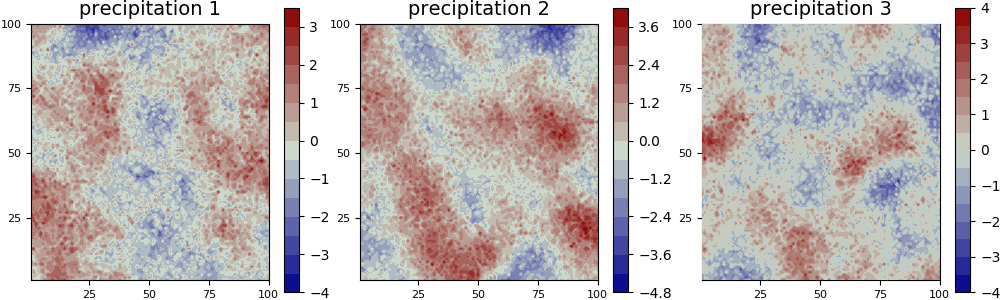

In [7]:
using Plots; pyplot()

plot(solution, size=(1000,300))